In [39]:
import os
import numpy as np
import xarray as xr
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV


In [40]:
# Load the NetCDF file
file_path = "LEAPCourse-Climate-Pred-Challenges/Project-StarterCodes/Project1-EDAV/lib/data/NA_data.nc"
ds = xr.open_dataset(file_path)

In [41]:
# Extract relevant variables
time = ds["time"].values
lat = ds["lat"].values
lon = ds["lon"].values
season = ds["season"].values
storm_speed = ds["storm_speed"].values
storm_dir = ds["storm_dir"].values

In [42]:
# Modify feature construction to add temporal features
window_size = 3  # Sliding window size

track_data = []
target_lat = []
target_lon = []

for i in range(lat.shape[0]):
    # Ensure sufficient historical data for the window
    for j in range(window_size, lat.shape[1]):  
        # Skip data points with missing values
        if np.isnan(lat[i, j]) or np.isnan(lon[i, j]):
            continue

        # Calculate target variables (Δlat and Δlon)
        delta_lat = lat[i, j] - lat[i, j-1]
        delta_lon = lon[i, j] - lon[i, j-1]

        # Extract temporal features -------------------------------------------------
        # Speed features
        speed_window = storm_speed[i, j-window_size:j]
        avg_speed = np.nanmean(speed_window)  # Window average speed
        # Calculate linear trend (slope) if window has valid values
        speed_trend = np.polyfit(range(window_size), speed_window, 1)[0] if not np.all(np.isnan(speed_window)) else 0

        # Direction features
        dir_window = storm_dir[i, j-window_size:j]
        avg_dir = np.nanmean(dir_window)  # Window average direction

        # Seasonal cyclical encoding (capture periodic patterns)
        season_sin = np.sin(2 * np.pi * season[i] / 12)  # Assume season represents month [1-12]
        season_cos = np.cos(2 * np.pi * season[i] / 12)

        # Construct feature vector --------------------------------------------------
        track_data.append([
            lat[i, j-1],                  # Previous latitude
            lon[i, j-1],                  # Previous longitude
            storm_speed[i, j-1],          # Current speed (t-1)
            avg_speed,                    # Window average speed
            speed_trend,                  # Speed trend in window
            storm_dir[i, j-1],            # Current direction (t-1) 
            avg_dir,                      # Window average direction
            season_sin, season_cos        # Seasonal encoding
        ])

        # Store targets
        target_lat.append(delta_lat)
        target_lon.append(delta_lon)

In [43]:
# Convert to NumPy arrays
X = np.array(track_data)
y_lat = np.array(target_lat)
y_lon = np.array(target_lon)

In [44]:
# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train_lat, y_test_lat, y_train_lon, y_test_lon = train_test_split(
    X, y_lat, y_lon, test_size=0.2, random_state=42
)

In [45]:
# Train XGBoost models for latitude and longitude shifts
xgb_lat = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, max_depth=5, learning_rate=0.1)
xgb_lon = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, max_depth=5, learning_rate=0.1)

xgb_lat.fit(X_train, y_train_lat)
xgb_lon.fit(X_train, y_train_lon)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [47]:
# Predict on test set
y_pred_lat = xgb_lat.predict(X_test)
y_pred_lon = xgb_lon.predict(X_test)

# Evaluate model performance
mse_lat = mean_squared_error(y_test_lat, y_pred_lat)
mse_lon = mean_squared_error(y_test_lon, y_pred_lon)

print(f"Mean Squared Error for Latitude Shift Prediction: {mse_lat}")
print(f"Mean Squared Error for Longitude Shift Prediction: {mse_lon}")

Mean Squared Error for Latitude Shift Prediction: 0.0037208087742328644
Mean Squared Error for Longitude Shift Prediction: 0.005513024516403675


Text(0.5, 1.0, 'Longitude Shift: Actual vs Predicted')

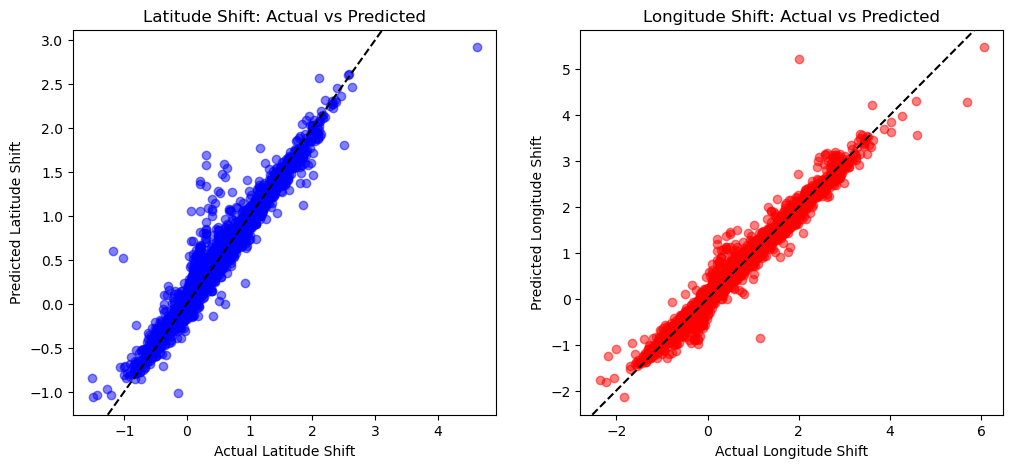

In [48]:
plt.figure(figsize=(12, 5))

# Latitude
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st plot
plt.scatter(y_test_lat, y_pred_lat, alpha=0.5, color="blue")
plt.axline((0, 0), slope=1, color="black", linestyle="--")  # Reference y = x line
plt.xlabel("Actual Latitude Shift")
plt.ylabel("Predicted Latitude Shift")
plt.title("Latitude Shift: Actual vs Predicted")

# Longitude
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd plot
plt.scatter(y_test_lon, y_pred_lon, alpha=0.5, color="red")
plt.axline((0, 0), slope=1, color="black", linestyle="--")  # Reference y = x line
plt.xlabel("Actual Longitude Shift")
plt.ylabel("Predicted Longitude Shift")
plt.title("Longitude Shift: Actual vs Predicted")

In [49]:
# Define hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'n_estimators': [50, 100, 200, 300],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'min_child_weight': [1, 3, 5, 7]
}

# Perform Randomized Grid Search for latitude shift prediction
xgb_model_lat = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
random_search_lat = RandomizedSearchCV(
    estimator=xgb_model_lat,
    param_distributions=param_grid,
    n_iter=50,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    random_state=42
)
random_search_lat.fit(X_train, y_train_lat)

# Best parameters for latitude
best_params_lat = random_search_lat.best_params_
print("Best Hyperparameters for Latitude:", best_params_lat)

# Train the final XGBoost model for latitude with best parameters
xgb_best_lat = xgb.XGBRegressor(objective="reg:squarederror", **best_params_lat)
xgb_best_lat.fit(X_train, y_train_lat)

# Predict and evaluate the tuned latitude model
y_pred_lat_tuned = xgb_best_lat.predict(X_test)
mse_lat_tuned = mean_squared_error(y_test_lat, y_pred_lat_tuned)
print(f"Mean Squared Error for Tuned Latitude Model: {mse_lat_tuned}")


# Perform Randomized Grid Search for longtitude shift prediction
xgb_model_lon = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
random_search_lon = RandomizedSearchCV(
    estimator=xgb_model_lon,
    param_distributions=param_grid,
    n_iter=50,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    random_state=42
)
random_search_lon.fit(X_train, y_train_lon)

# Best parameters for longitude
best_params_lon = random_search_lon.best_params_
print("Best Hyperparameters for Longitude:", best_params_lon)

# Train the final XGBoost model for longitude with best parameters
xgb_best_lon = xgb.XGBRegressor(objective="reg:squarederror", **best_params_lon)
xgb_best_lon.fit(X_train, y_train_lon)

# Predict and evaluate the tuned longitude model
y_pred_lon_tuned = xgb_best_lon.predict(X_test)
mse_lon_tuned = mean_squared_error(y_test_lon, y_pred_lon_tuned)
print(f"Mean Squared Error for Tuned Longitude Model: {mse_lon_tuned}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Hyperparameters for Latitude: {'subsample': 1.0, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Mean Squared Error for Tuned Latitude Model: 0.0031199289951473475
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Hyperparameters for Longitude: {'subsample': 1.0, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
Mean Squared Error for Tuned Longitude Model: 0.004588593263179064


In [51]:
from sklearn.model_selection import cross_val_score

# kfold
cv_scores_lat = cross_val_score(
    xgb.XGBRegressor(objective="reg:squarederror"),
    X, y_lat,
    cv=5,  # 5fold
    scoring="neg_mean_squared_error"  # 使用负均方误差（sklearn约定）
)

# average MSE
mse_lat_cv = -cv_scores_lat.mean()
print(f"交叉验证MSE（纬度）: {mse_lat_cv:.10f}")

交叉验证MSE（纬度）: 0.0034897726


In [35]:
time

array([['1851-06-23T12:00:00.000040224', '1851-06-23T15:00:00.000040224',
        '1851-06-23T18:00:00.000040224', ...,
                                  'NaT',                           'NaT',
                                  'NaT'],
       ['1851-06-29T12:00:00.000040224', '1851-06-29T15:00:00.000040224',
        '1851-06-29T18:00:00.000040224', ...,
                                  'NaT',                           'NaT',
                                  'NaT'],
       ['1851-07-05T12:00:00.000040224',                           'NaT',
                                  'NaT', ...,
                                  'NaT',                           'NaT',
                                  'NaT'],
       ...,
       ['2023-10-18T18:00:00.000039936', '2023-10-18T21:00:00.000039936',
        '2023-10-19T00:00:00.000039936', ...,
                                  'NaT',                           'NaT',
                                  'NaT'],
       ['2023-10-23T12:00:00.000039936', '20